### Project: Content Recommendation + User Retention system for OTT

Aim of the project:
- To recommend content to the users based on their interactions with the OTT platform.
- This helps them get into a habit of regularly visiting the platform and engaging with the content, which in turn helps the platform to increase the user engagement, and hence the user base.
- This finally helps with user retention and user satisfaction.
- If recommendations are not possible, we need to recommend the Top 10 movies with the most ratings.

### Package installation and import

In [65]:
# %pip install numpy pandas scikit-learn matplotlib seaborn

In [66]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from common_functions import download_and_extract_dataset_zip, datasets_dir, RANDOM_STATE

np.random.seed(RANDOM_STATE)

### Data collection

In [67]:
dataset_foldername = 'ml-latest-small'

zip_file_path = os.path.join(datasets_dir, dataset_foldername + '.zip')
extracted_folder_path = zip_file_path.replace('.zip', '')
ratings_file = os.path.join(extracted_folder_path, 'ratings.csv')
movies_file = os.path.join(extracted_folder_path, 'movies.csv')
user_tags_file = os.path.join(extracted_folder_path, 'tags.csv')

required_files = [ratings_file, movies_file, user_tags_file]
dataset_zip_url = f'https://files.grouplens.org/datasets/movielens/{dataset_foldername}.zip'

# if the dataset files don't exist
download_and_extract_dataset_zip(dataset_zip_url, required_files)

# Load the ratings, movies, and user_tags dataframes
ratings = pd.read_csv(ratings_file)
movies = pd.read_csv(movies_file)
user_tags = pd.read_csv(user_tags_file)

print(f'Dimensions of ratings: {ratings.shape}')
ratings.head()

Dimensions of ratings: (100836, 4)


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [68]:
print(f'Dimensions of movies: {movies.shape}')
movies.head()

Dimensions of movies: (9742, 3)


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [69]:
print(f'Dimensions of user_tags: {user_tags.shape}')
user_tags.head()

Dimensions of user_tags: (3683, 4)


,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


### Data Transformation

In [70]:
# Data Cleaning
# Drop any rows with missing values from the ratings, movies and user_tags dataframes
ratings.dropna(inplace=True)
movies.dropna(inplace=True)
user_tags.dropna(inplace=True)

user_tags.rename(columns={'tag': 'user_tag'}, inplace=True)

# Data Manipulation and Wrangling
# drop timestamp
ratings.drop(columns=['timestamp'], inplace=True)
user_tags.drop(columns=['timestamp'], inplace=True)

movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


### Data Preprocessing

In [71]:
# in movies, if genre is '(no genres listed)', replace with NA
movies['genres'] = movies['genres'].apply(lambda x: x if x != '(no genres listed)' else None)

# Handle missing values
movies['genres'].fillna('', inplace=True)

# Split genres into a list in movies dataframe
if not isinstance(movies['genres'].iloc[0], list):
    movies['genres'] = movies['genres'].str.split('|')

# Merge the dataframes on 'movieId' to create a single dataframe
merged_df = pd.merge(ratings, movies, on='movieId')
merged_df.drop(columns=['title'], inplace=True)  # drop movie title
merged_df = pd.merge(merged_df, user_tags, on=['movieId', 'userId'], how='left')

if merged_df.isnull().sum().any():
    columns_with_missing_values = merged_df.columns[merged_df.isnull().any()].tolist()
    columns_with_missing_values = ', '.join(columns_with_missing_values)
    print(f'There are missing values in columns: {columns_with_missing_values}')

# Normalize the data
merged_df['rating'] = (merged_df['rating'] - merged_df['rating'].min()) / (merged_df['rating'].max() - merged_df['rating'].min())

merged_df.head()

There are missing values in columns: user_tag


,userId,movieId,rating,genres,user_tag
0,1,1,0.777778,"[Adventure, Animation, Children, Comedy, Fantasy]",NaN
1,5,1,0.777778,"[Adventure, Animation, Children, Comedy, Fantasy]",NaN
2,7,1,0.888889,"[Adventure, Animation, Children, Comedy, Fantasy]",NaN
3,15,1,0.444444,"[Adventure, Animation, Children, Comedy, Fantasy]",NaN
4,17,1,0.888889,"[Adventure, Animation, Children, Comedy, Fantasy]",NaN


In [72]:
# display where merged_ratings_df is not null
merged_df[merged_df['user_tag'].notnull()].head()

,userId,movieId,rating,genres,user_tag
121,336,1,0.777778,"[Adventure, Animation, Children, Comedy, Fantasy]",pixar
164,474,1,0.777778,"[Adventure, Animation, Children, Comedy, Fantasy]",pixar
193,567,1,0.666667,"[Adventure, Animation, Children, Comedy, Fantasy]",fun
241,289,3,0.444444,"[Comedy, Romance]",moldy
242,289,3,0.444444,"[Comedy, Romance]",old


In [73]:
# Calculate the average rating of each movie
movies['average_rating'] = ratings.groupby('movieId')['rating'].mean()
# Calculate the number of ratings of each movie
movies['number_of_ratings'] = ratings.groupby('movieId')['rating'].count()

movies = movies.set_index('movieId')

movies.head()

,title,genres,average_rating,number_of_ratings
movieId,,,,
1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",NaN,NaN
2,Jumanji (1995),"[Adventure, Children, Fantasy]",3.920930,215.0
3,Grumpier Old Men (1995),"[Comedy, Romance]",3.431818,110.0
4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",3.259615,52.0
5,Father of the Bride Part II (1995),[Comedy],2.357143,7.0


### Data Exploration

#### EDA

In [74]:
print('Ratings Dataframe Info:')
print(ratings.info())
print('\nMovies Dataframe Info:')
print(movies.info())
print('\nUser Tags Dataframe Info:')
print(user_tags.info())

Ratings Dataframe Info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 100836 entries, 0 to 100835
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   100836 non-null  int64  
 1   movieId  100836 non-null  int64  
 2   rating   100836 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 3.1 MB
None

Movies Dataframe Info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 9742 entries, 1 to 193609
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              9742 non-null   object 
 1   genres             9742 non-null   object 
 2   average_rating     5390 non-null   float64
 3   number_of_ratings  5390 non-null   float64
dtypes: float64(2), object(2)
memory usage: 380.5+ KB
None

User Tags Dataframe Info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3683 entries, 0 to 3682
Data columns (total 3 columns):
 #  

#### Data Visualization

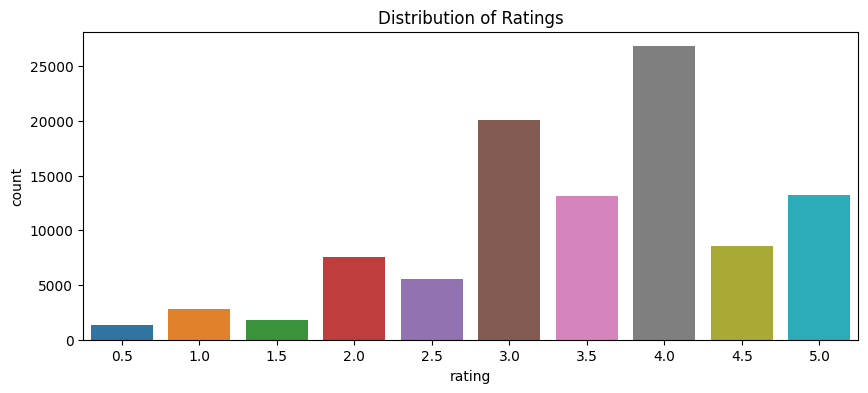

In [75]:
# Distribution of ratings
plt.figure(figsize=(10, 4))
sns.countplot(x='rating', data=ratings)
plt.title('Distribution of Ratings')
plt.show()

#### Top 10 movies with the most ratings

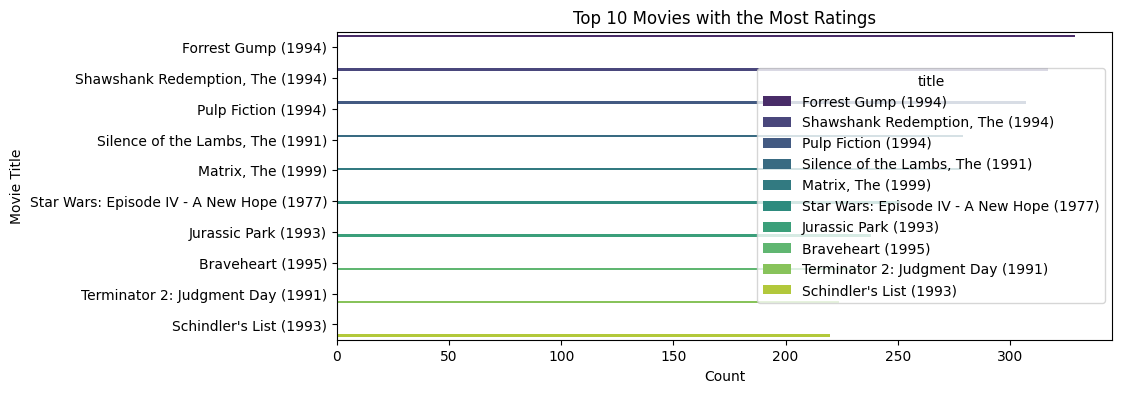

In [76]:
top_movies = ratings['movieId'].value_counts()[:10]
top_movies = pd.DataFrame({'movieId': top_movies.index, 'count': top_movies.values})
top_movies = pd.merge(top_movies, movies, on='movieId')

plt.figure(figsize=(10, 4))
sns.barplot(x='count', y='title', hue='title', data=top_movies, palette='viridis')
plt.title('Top 10 Movies with the Most Ratings')
plt.xlabel('Count')
plt.ylabel('Movie Title')
plt.show()

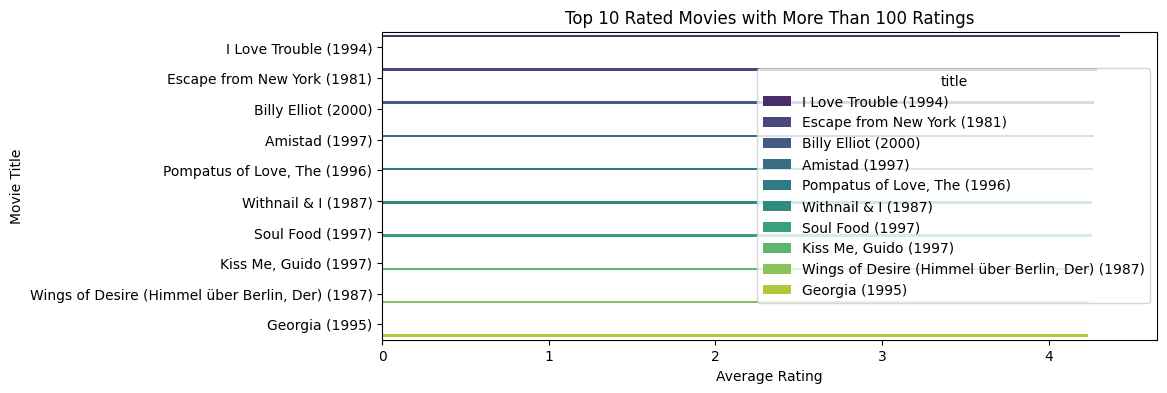

In [77]:
# Consider movies with more than specific ratings
movies_to_consider = movies[movies['number_of_ratings'] >= 50]
top_rated_movies = movies_to_consider.sort_values('average_rating', ascending=False)[:10]

# Plot the top 10 rated movies
plt.figure(figsize=(10, 4))
sns.barplot(x='average_rating', y='title', hue='title', data=top_rated_movies, palette='viridis')
plt.title('Top 10 Rated Movies with More Than 100 Ratings')
plt.xlabel('Average Rating')
plt.ylabel('Movie Title')
plt.show()

### Feature Engineering

#### Feature Selection

#### Feature Extraction

#### Feature Scaling

#### Visualization of the selected features with pair plots

#### Correlation Matrix

### Prediction

In [78]:
from surprise import Reader, Dataset, SVD

reader = Reader(rating_scale=(0, 1))

# Load the data from the dataframe
data = Dataset.load_from_df(merged_df[['userId', 'movieId', 'rating']], reader)
model = SVD()  # Use the SVD algorithm

# Train the algorithm on the whole dataset
print('Training the model...')
trainset = data.build_full_trainset()
model.fit(trainset)
print('Done')

Training the model...
Done


In [79]:
# Predict ratings for all pairs (u, i) that are NOT in the training set
print('Testing the model...')
testset = trainset.build_anti_testset()
predictions = model.test(testset)

# Print the first few predictions
for uid, iid, true_r, est, _ in predictions[:5]:
	print(f'User {uid} would rate movie {iid} with {est}')

# find accuracy
from surprise import accuracy

print('\n\nAccuracy Metrics:')
accuracy.rmse(predictions)
accuracy.mae(predictions)
accuracy.mse(predictions)

Testing the model...
User 1 would rate movie 318 with 1
User 1 would rate movie 1704 with 0.9248911339246826
User 1 would rate movie 6874 with 0.9188497867713541
User 1 would rate movie 8798 with 0.8768604815213337
User 1 would rate movie 46970 with 0.8062784142353187


Accuracy Metrics:
RMSE: 0.1332
MAE:  0.1048
MSE: 0.0177


0.01774623985315659

In [80]:
# given a user ID, recommend movies
def recommend_movies(user_id, top_n=10):
	# Get a list of all movie IDs
	all_movie_ids = merged_df['movieId'].unique()
	
	# Get a list of movie IDs that the user has already rated
	movie_ids_rated_by_user = merged_df[merged_df['userId'] == user_id]['movieId'].unique()
	
	# Remove the movie IDs that the user has already rated
	movie_ids_to_predict = np.setdiff1d(all_movie_ids, movie_ids_rated_by_user)
	
	# Create a testset with the user ID and the movie IDs to predict
	testset = [[user_id, movie_id, 0] for movie_id in movie_ids_to_predict]
	
	# Predict the ratings
	predictions = model.test(testset)
	
	# Create a list of the top N recommendations
	top_n_recommendations = []
	for uid, iid, true_r, est, _ in predictions:
		top_n_recommendations.append((iid, est))
	
	# Sort the list by estimated ratings
	top_n_recommendations.sort(key=lambda x: x[1], reverse=True)
	
	# Get the top N movie IDs
	top_n_movie_ids = [movie_id for movie_id, _ in top_n_recommendations[:top_n]]
	
	# Get the movie titles
	top_n_movie_titles = movies.loc[top_n_movie_ids, 'title']
	
	return top_n_movie_titles

# Get the top 10 movie recommendations for user 123
print('Top 10 Movie Recommendations for User 123:')
recommend_movies(123, top_n=10)

Top 10 Movie Recommendations for User 123:


movieId
1203                                    12 Angry Men (1957)
1261                     Evil Dead II (Dead by Dawn) (1987)
1358                                     Sling Blade (1996)
3266      Man Bites Dog (C'est arrivé près de chez vous)...
3275                            Boondock Saints, The (2000)
3378                         Ogre, The (Unhold, Der) (1996)
4011                                          Snatch (2000)
7044                                   Wild at Heart (1990)
74510     Girl Who Played with Fire, The (Flickan som le...
158966                             Captain Fantastic (2016)
Name: title, dtype: object

In [81]:
# Perform cross validation and store the results
from surprise.model_selection import cross_validate
cv_results = cross_validate(model, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Print the average RMSE and MAE over the 5 folds
print(f"Average RMSE: {np.mean(cv_results['test_rmse'])}")
print(f"Average MAE: {np.mean(cv_results['test_mae'])}")

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.1993  0.1997  0.1991  0.1989  0.1996  0.1993  0.0003  
MAE (testset)     0.1538  0.1539  0.1538  0.1533  0.1535  0.1537  0.0002  
Fit time          0.62    0.67    0.64    0.68    0.63    0.65    0.02    
Test time         0.05    0.05    0.05    0.05    0.05    0.05    0.00    
Average RMSE: 0.19933298246726414
Average MAE: 0.15365970635871398
